In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle(fit_options.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.00000,6251.000000,6251.000000,6251.000000,6251.000000,6185.000000,6251.000000,6251.000000,6251.000000,6251.0,6251.000000,6251.000000,6251.000000,6251.000000
mean,10.539754,604.216765,1.490162,598.748071,0.018907,3957.958727,3808.092725,12.225724,28.039674,37.679251,108.799072,1.01804,0.988365,0.994420,1.001760,1.005919,0.207669,32.246559,55.161894,148.545993,1.0,0.073268,2.998080,0.987581,1.027236
std,7.143925,389.951541,0.983231,395.586862,0.987593,962.682216,1024.731656,3.384683,2.612284,8.012329,15.999728,0.30429,0.059484,0.044932,0.117807,0.117834,0.046656,36.406872,27.743413,60.567634,0.0,0.514501,20.567088,0.037777,0.069380
min,1.000000,245.000000,1.000000,-1.000000,-12.780000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.52000,0.890000,0.920000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,354.000000,1.000000,352.475000,-0.290000,3300.000000,2954.070000,10.000000,26.000000,32.000000,98.000000,0.80000,1.000000,1.000000,1.000000,1.000000,0.180000,12.820000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,460.000000,1.000000,458.090000,-0.020000,3900.000000,3796.100000,12.000000,28.000000,36.000000,103.000000,0.94000,1.000000,1.000000,1.000000,1.000000,0.200000,19.750000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,711.000000,2.000000,711.185000,0.270000,4500.000000,4455.000000,14.000000,31.000000,41.000000,115.000000,1.21000,1.000000,1.000000,1.000000,1.000000,0.240000,43.980000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.330000,15.410000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.41000,1.120000,1.080000,1.200000,1.200000,0.420000,414.030000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.41,0.41,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.37,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.69,-0.31,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.08,0.08,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.85,-0.15,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.52,937.81,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.65,-0.35,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.23,750.25,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = make_precomputed_columns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"] - RP(x)


In [7]:
filename = fit_options.result_file(digest(data, x0))
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.563e-01  2.545e-01 ...  2.195e-01  9.953e-01]
       cost: 1119.3668854526234
       grad: [ 2.956e-05 -3.122e-05 ...  8.217e-05 -7.706e-05]
 optimality: 2.1351560882176273
       nfev: 21
       njev: 16

In [8]:
# What are the worst points?

df = data[["Pokemon","ID","Level","Class","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
2801,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,Ingredients,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1700.141203,12.858797,165.348661
1234,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,Ingredients,18.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1891.200237,12.799763,163.833922
2802,Victreebel,VictreebelNeutral323Energy Recovery BonusInven...,32.0,Ingredients,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1751.0,1738.335496,12.664504,160.389650
2803,Victreebel,VictreebelNeutral333Energy Recovery BonusInven...,33.0,Ingredients,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1769.0,1757.224383,11.775617,138.665151
2159,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,Berries,21.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1743.154336,10.845664,117.628418
2817,Walrein,WalreinImpish333Berry Finding SHelping bonus,33.0,Berries,18.0,3.0,Energy Recovery,Ingredient Finding,Berry Finding S,Helping bonus,2205.0,2215.030370,-10.030370,100.608313
2603,Togekiss,TogekissGentle103Skill Trigger M,10.0,Skills,16.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.644307,9.355693,87.528992
2205,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,Berries,16.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1240.686125,9.313875,86.748266
398,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,Ingredients,19.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.706893,9.293107,86.361842
427,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,Ingredients,19.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.064403,8.935597,79.844894


intercept,-0.00564806
intercept_stderr,0.0212022
pvalue,0.517945
rvalue,-0.00817871
slope,-0.00107665
stderr,0.00166522


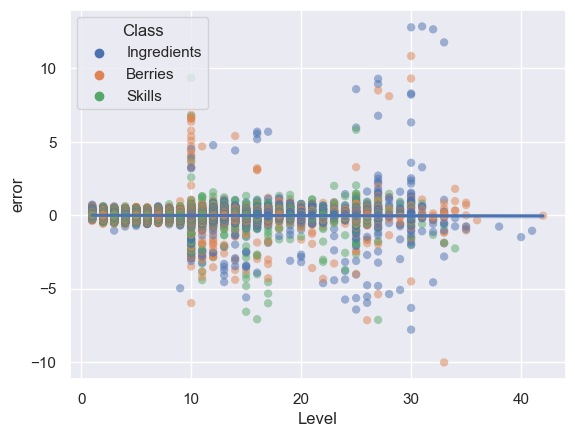

In [9]:
# Plot error vs level

err = df[["Level","error","Class"]]
palette = sns.color_palette(n_colors=3)

_ = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0, palette=palette)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

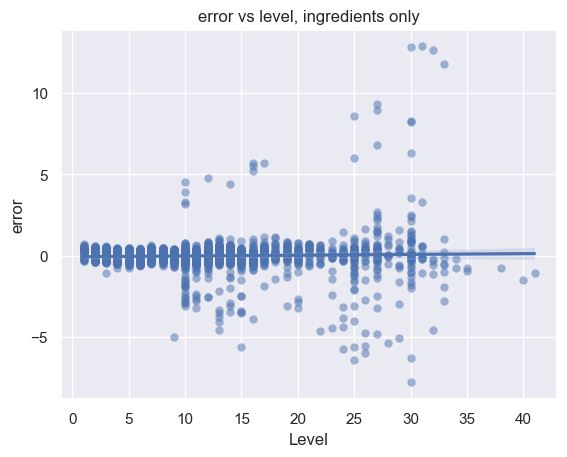

In [10]:
err2 = err[ err["Class"]=="Ingredients" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[0])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, ingredients only')


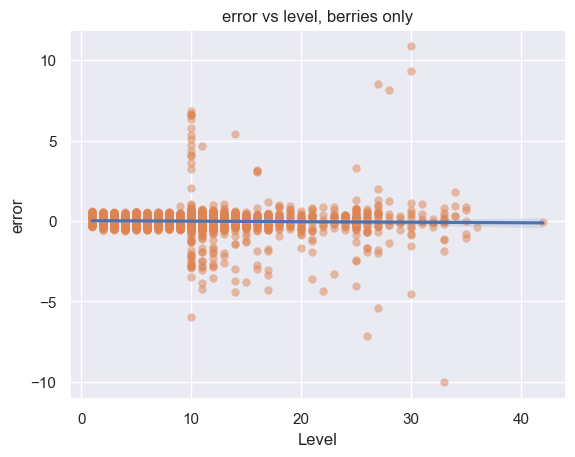

In [11]:
err2 = err[ err["Class"]=="Berries" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[1])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, berries only')

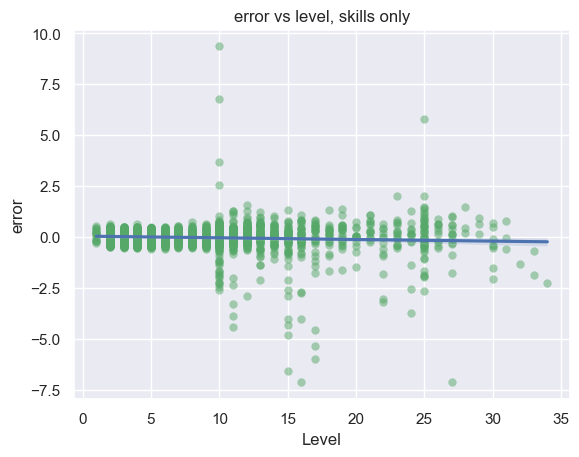

In [12]:
err2 = err[ err["Class"]=="Skills" ]

p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[2])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, skills only')


intercept,0.0118188
intercept_stderr,0.0177254
pvalue,0.0126679
rvalue,-0.0369924
slope,-0.00482149
stderr,0.00193327


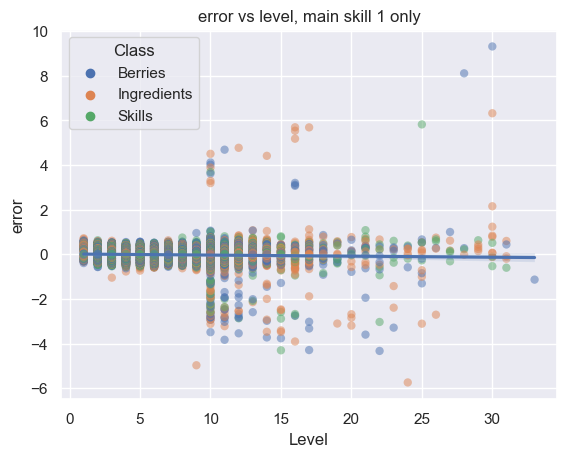

In [13]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error","Class"]].loc[df["MS lvl"]==1]

p = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

_ = p.set(title='error vs level, main skill 1 only')

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

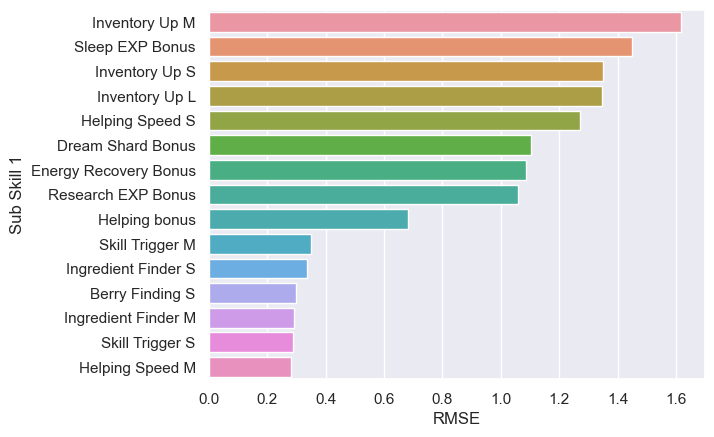

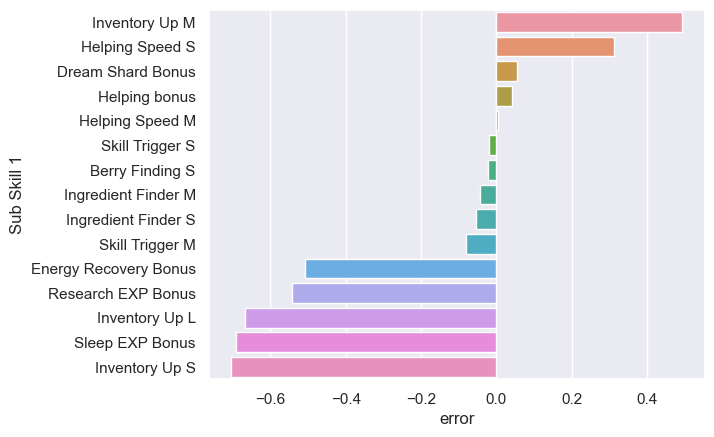

In [14]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


intercept,0.0118188
intercept_stderr,0.0177254
pvalue,0.0126679
rvalue,-0.0369924
slope,-0.00482149
stderr,0.00193327


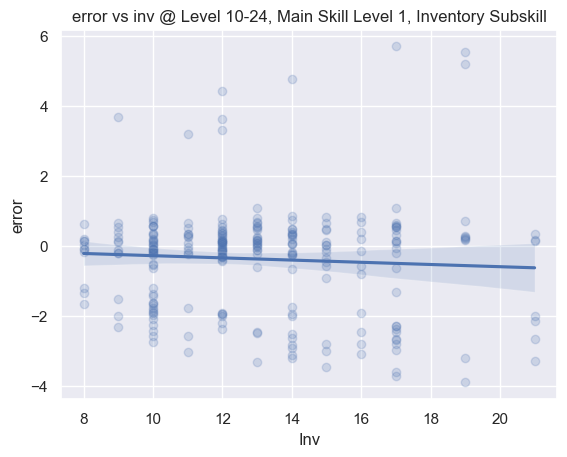

In [15]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"].str.contains("Inventory")) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')]

intercept,0.0118188
intercept_stderr,0.0177254
pvalue,0.0126679
rvalue,-0.0369924
slope,-0.00482149
stderr,0.00193327


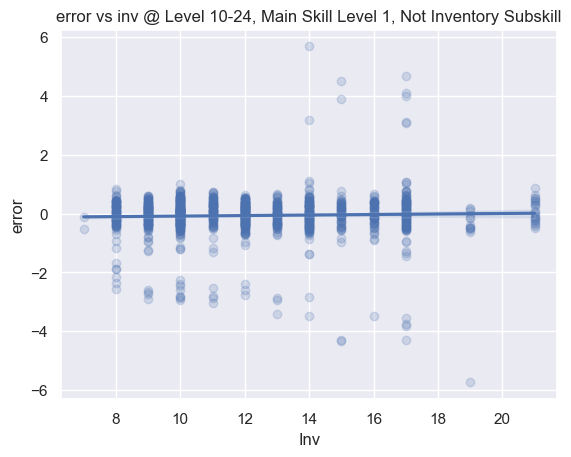

In [16]:
# Let's see what happens at level 10-24, main skill 1, and not inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]>9) & (df["Level"]<25) & (df["MS lvl"]==1) & ( ~df["Sub Skill 1"].str.contains("Inventory") ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

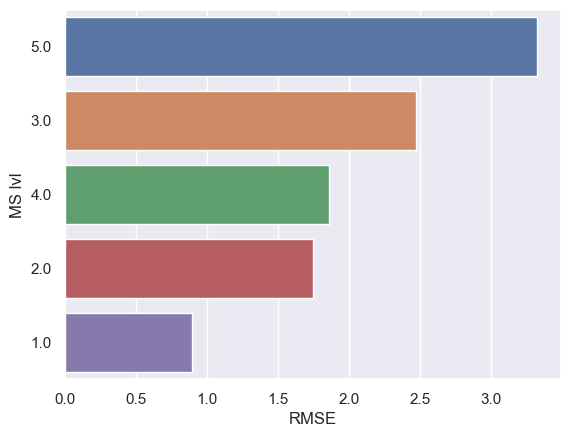

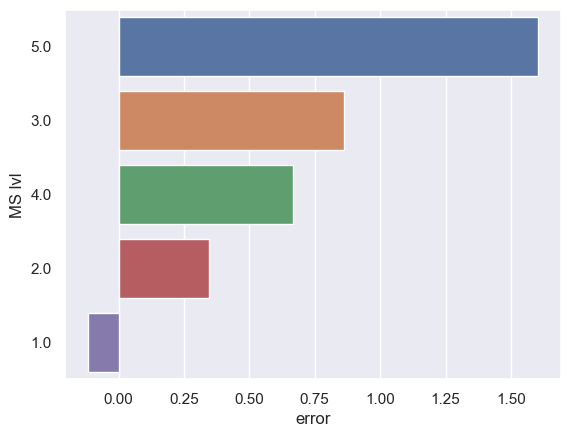

In [17]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


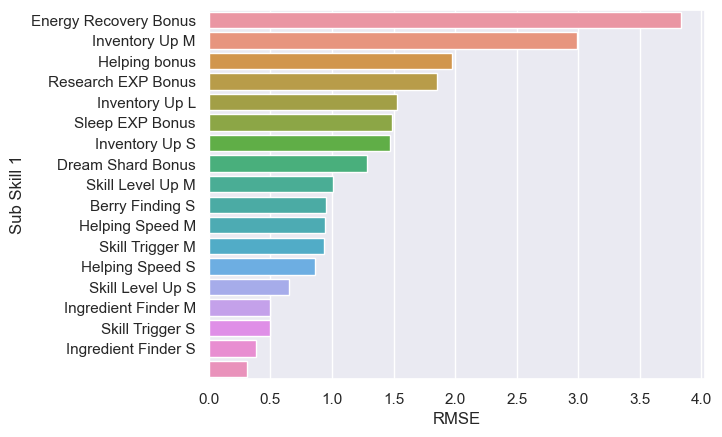

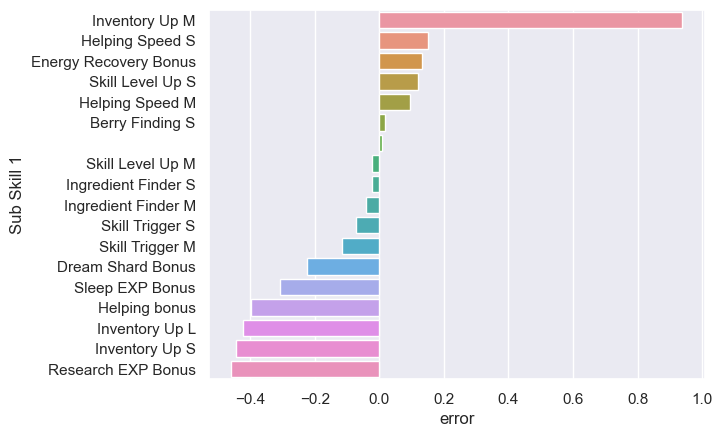

In [18]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

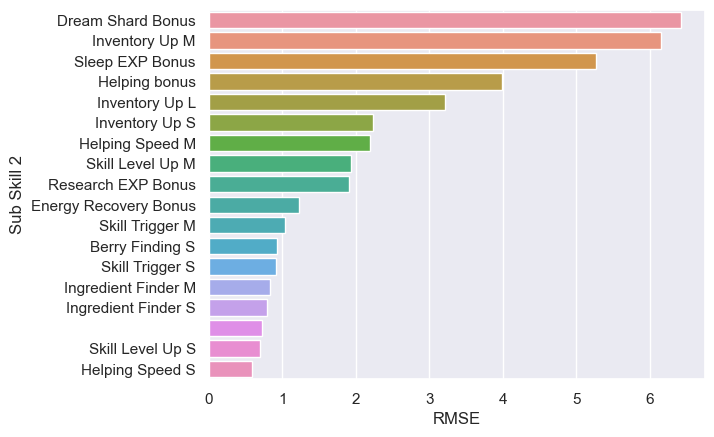

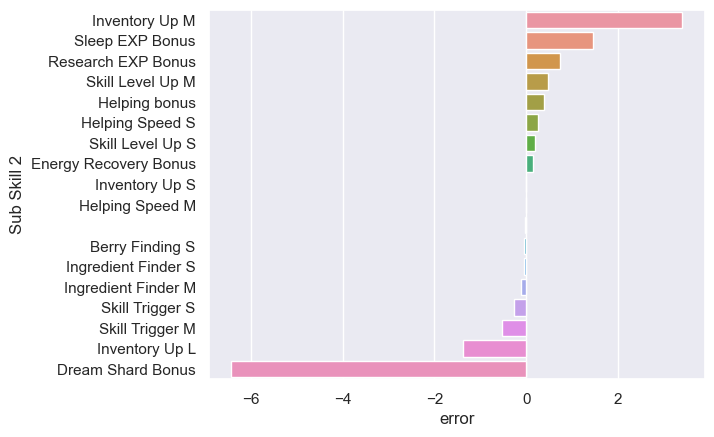

In [19]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")